In [1]:
import librosa
import scipy
import os
import numpy as np
from tqdm.notebook import tqdm
import soundfile
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
data_dir = "./vlsp2020_train_set_02/"
filelist = os.listdir(data_dir)
filelist = [file for file in filelist if "speaker" in file and ".wav" in file]

In [3]:
filelist.sort()

In [30]:
sample_path = filelist[13000]
au, sr = librosa.load(os.path.join(data_dir, sample_path))

In [31]:
Audio(data=au, rate=sr)

In [33]:
clip, _ = librosa.effects.trim(au, top_db=20)

In [34]:
Audio(data=clip, rate=sr)

# Data Exploration

In [4]:
duration = np.zeros(len(filelist))
for i, file in tqdm(enumerate(filelist)):
    duration[i] = librosa.get_duration(filename=os.path.join(data_dir, file))

0it [00:00, ?it/s]

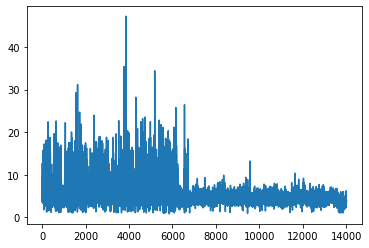

In [5]:
plt.plot(duration)

In [6]:
print("Min len", np.min(duration))
print("Max len", np.max(duration))

Min len 0.81
Max len 47.23


In [7]:
# filter too long (> 25) and too short (< 2) audio
filtered_duration = []
filtered_files = []
for i, d in enumerate(duration):
    if d < 2 or d > 25:
        continue
    filtered_duration.append(d)
    filtered_files.append(filelist[i])

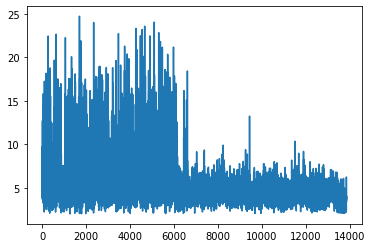

In [8]:
plt.plot(filtered_duration)

In [12]:
with open("filtered_files.txt", "w") as f:
    for line in filtered_files:
        f.write(line + "\n")

## Trim data

In [57]:
target_dir = "./vlsp2020_wav/"

In [61]:
for file in tqdm(filtered_files):
    au, sr = librosa.load(os.path.join(data_dir, file))
    clip, _ = librosa.effects.trim(au, top_db=20)
    soundfile.write(target_dir + file, clip, sr)

  0%|          | 0/13861 [00:00<?, ?it/s]

## Cluster data

In [62]:
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path

In [63]:
encoder = VoiceEncoder()

Loaded the voice encoder model on cpu in 0.02 seconds.


In [64]:
def get_au_feat(path):
    fpath = Path(path)
    wav = preprocess_wav(fpath)
    return encoder.embed_utterance(wav)

In [68]:
feat_data = np.zeros((len(filtered_files), 256))
for i, file in tqdm(enumerate(filtered_files)):
    feat_data[i] = get_au_feat(os.path.join(target_dir, file))

0it [00:00, ?it/s]

In [69]:
with open("feat_data.npy", "wb") as f:
    np.save(f, feat_data)

In [71]:
feat_data

array([[0.18967925, 0.        , 0.03298119, ..., 0.        , 0.        ,
        0.        ],
       [0.18690382, 0.        , 0.07890707, ..., 0.        , 0.        ,
        0.        ],
       [0.20408252, 0.00041361, 0.08161834, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01303046, 0.05073546, 0.03363058, ..., 0.        , 0.        ,
        0.        ],
       [0.00371295, 0.02167987, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05000982, 0.05002282, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [78]:
# find number of clusters
spkr_set = set()
for file in filtered_files:
    idx = int(file.split("-")[0].split("_")[1])
    spkr_set.add(idx)

In [79]:
print("Number of speakers", len(spkr_set))

Number of speakers 759


In [80]:
spkr_set

{9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 29,
 32,
 33,
 34,
 36,
 39,
 41,
 42,
 43,
 45,
 47,
 48,
 49,
 50,
 51,
 55,
 58,
 59,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 70,
 71,
 73,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 136,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 169,
 170,
 172,
 173,
 174,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 185,
 186,
 188,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 221,
 222,
 223,
 225,
 226,
 227,
 229,
 230,
 231,
 232

In [73]:
from sklearn.cluster import KMeans

In [81]:
kmean = KMeans(n_clusters=1000).fit(feat_data)

In [92]:
kmean.predict(feat_data[0:20])

array([922, 922, 514, 922, 846, 514, 922, 514, 846, 846, 922, 922, 922,
       846, 846, 846, 561, 363, 363, 363], dtype=int32)

In [93]:
labels = kmean.predict(feat_data)

In [97]:
offset = 100

## Process text

In [102]:
def get_text(path):
    with open(path, "r") as f:
        data = f.readlines()
    return data[0]

In [103]:
get_text(os.path.join(data_dir, filtered_files[0].replace(".wav", ".txt")))

'ở vị trí chính giữa bức tường ngăn được vẽ hình rông phun nước bay lượn trong mây'

In [104]:
text = []
for file in filtered_files:
    text.append(get_text(os.path.join(data_dir, file.replace(".wav", ".txt"))))

In [106]:
import string

In [113]:
remove_indices = set()
for i, line in enumerate(text):
    for c in line:
        if c in string.punctuation:
            print(i, c)
            remove_indices.add(i)

10 <
10 >
10 <
10 >
37 <
37 >
63 <
63 >
78 <
78 >
116 <
116 >
129 <
129 >
187 <
187 >
197 <
197 >
220 <
220 >
299 <
299 >
300 <
300 >
301 <
301 >
338 <
338 >
340 <
340 >
341 <
341 >
343 <
343 >
380 <
380 >
490 <
490 >
517 <
517 >
586 <
586 >
592 <
592 >
627 <
627 >
644 <
644 >
650 <
650 >
661 <
661 >
676 <
676 >
719 <
719 >
779 <
779 >
836 <
836 >
842 <
842 >
1102 <
1102 >
1104 <
1104 >
1128 <
1128 >
1130 <
1130 >
1160 <
1160 >
1206 <
1206 >
1224 <
1224 >
1228 <
1228 >
1263 <
1263 >
1265 <
1265 >
1268 <
1268 >
1268 <
1268 >
1271 <
1271 >
1297 <
1297 >
1302 <
1302 >
1349 <
1349 >
1371 <
1371 >
1381 <
1381 >
1382 <
1382 >
1386 <
1386 >
1415 <
1415 >
1488 <
1488 >
1516 <
1516 >
1517 <
1517 >
1517 <
1517 >
1522 <
1522 >
1580 <
1580 >
1581 <
1581 >
1657 <
1657 >
1693 <
1693 >
1699 <
1699 >
1745 <
1745 >
1746 <
1746 >
1754 <
1754 >
1767 <
1767 >
1774 <
1774 >
1776 <
1776 >
1792 <
1792 >
1793 <
1793 >
1796 <
1796 >
1797 <
1797 >
1830 <
1830 >
1838 <
1838 >
1867 <
1867 >
1912 <
1912 >
1943 <
1

In [115]:
len(remove_indices)

289

In [116]:
import pandas as pd

In [128]:
data = []
for file, spkr, t in zip(filtered_files, labels, text):
    data.append([file, spkr+offset, t.lower()])

In [129]:
clean_data = []
for i, d in enumerate(data):
    if i in remove_indices:
        continue
    clean_data.append(d)

In [130]:
df = pd.DataFrame(clean_data, columns=['filename', 'spkr_id', 'sentence'])

In [131]:
df.head()

,filename,spkr_id,sentence
0,speaker_009-000005-1.wav,1022,ở vị trí chính giữa bức tường ngăn được vẽ hìn...
1,speaker_009-004101-1.wav,1022,tiếp theo sùng trinh phái đại học sĩ binh bộ t...
2,speaker_009-005125-1.wav,614,tuyến sông trên địa bàn tỉnh quảng nam có dòng...
3,speaker_009-007429-1.wav,1022,chỉ có tang đồ theo hạng vũ là người duy nhất ...
4,speaker_009-007685-1.wav,946,sau đó chủ nhà mời khách uống trà ăn trầu hay ...


In [132]:
df.to_csv("vlsp_corpus.csv", index=False)